In [1]:
import pandas as pd
import numpy as np
from tpot import TPOTClassifier
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

# Data preparation

## Load fingerprints

In [2]:
# Load pd_train
pd_train = pd.read_parquet("data/training_class.parquet")
pd_train["label"] = pd_train["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)
print(pd_train["Class"].value_counts())
pd_train.head()

(1241, 16094)
Class
Hepatotoxicity       683
NonHepatotoxicity    558
Name: count, dtype: int64


,Class,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,...,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X,label
0,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
# Load pd_test
pd_test = pd.read_parquet("data/testing_class.parquet")
pd_test["label"] = pd_test["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
print(pd_test["Class"].value_counts())
pd_test.head()

(286, 16094)
Class
Hepatotoxicity       221
NonHepatotoxicity     65
Name: count, dtype: int64


,Class,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,...,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X,label
0,Hepatotoxicity,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,Hepatotoxicity,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Hepatotoxicity,0,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,Hepatotoxicity,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Hepatotoxicity,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
X_train_fingerprints = pd_train.drop(columns=["Class", "label"])
X_test_fingerprints = pd_test.drop(columns=["Class", "label"])
print(X_train_fingerprints.shape)
print(X_test_fingerprints.shape)

(1241, 16092)
(286, 16092)


## Load embeddings

In [8]:
# load the embeddings
pd_train_smiles = joblib.load("data_smiles/Training_Group_openai_embeddings.pkl")
pd_test_smiles = joblib.load("data_smiles/Testing_Group_openai_embeddings.pkl")

print(pd_train_smiles.shape)
print(pd_test_smiles.shape)

(1241, 4)
(286, 4)


In [9]:
pd_train_smiles.head()

,Smiles,Liver,label,Embeddings
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity,1,"[-0.004447528443423119, 0.0031313571253721558,..."
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity,1,"[0.009968860143216834, -0.014082992545945338, ..."
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity,1,"[0.005174644720609798, -0.009468640134092616, ..."
3,O(CCO)CC,Hepatotoxicity,1,"[-0.011113415371026608, -0.009221059186249353,..."
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity,1,"[-0.0055689253863648825, -0.002680601606572984..."


In [11]:
X_train_embedding = np.vstack(
    pd_train_smiles["Embeddings"].values
)  # Stack Embeddings into a 2D array
X_test_embedding = np.vstack(
    pd_test_smiles["Embeddings"].values
)  # Stack embeddings into a 2D array

print(X_train_embedding.shape)
print(X_test_embedding.shape)

(1241, 1536)
(286, 1536)


## Combine features

In [12]:
# combine fingerprints and embeddings
X_train = np.hstack([X_train_fingerprints, X_train_embedding])
X_test = np.hstack([X_test_fingerprints, X_test_embedding])
print(X_train.shape)
print(X_test.shape)

(1241, 17628)
(286, 17628)


In [13]:
y_train = pd_train["label"].values
y_test = pd_test["label"].values
print(y_train.shape)
print(y_test.shape)

(1241,)
(286,)


In [14]:
# save the data
np.save("data_combined/X_train_openai_fingerprints.npy", X_train)
np.save("data_combined/X_test_openai_fingerprints.npy", X_test)
np.save("data_combined/y_train_openai_fingerprints.npy", y_train)
np.save("data_combined/y_test_openai_fingerprints.npy", y_test)

# Model training (PCA NLP + PCA fingerprints)

## TPOT classifier

In [15]:
# load the data
X_train = np.load("data_combined/X_train_openai_fingerprints.npy")
X_test = np.load("data_combined/X_test_openai_fingerprints.npy")
y_train = np.load("data_combined/y_train_openai_fingerprints.npy")
y_test = np.load("data_combined/y_test_openai_fingerprints.npy")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1241, 17628)
(286, 17628)
(1241,)
(286,)


In [31]:
# Apply PCA fingerprints
n_components = 100
pca_fingerprints = PCA(n_components=n_components)
X_train_pca_fingerprints = pca_fingerprints.fit_transform(X_train[:, :16092])
X_test_pca_fingerprints = pca_fingerprints.transform(X_test[:, :16092])
print(X_train_pca_fingerprints.shape)
print(X_test_pca_fingerprints.shape)

# Apply PCA NLP
# n_components = 10
# pca_nlp = PCA(n_components=n_components)
# X_train_pca_nlp = pca_nlp.fit_transform(X_train[:, -1536:])
# X_test_pca_nlp = pca_nlp.transform(X_test[:, -1536:])
# print(X_train_pca_nlp.shape)
# print(X_test_pca_nlp.shape)

X_train_pca_nlp = X_train[:, -1536:].copy()
X_test_pca_nlp = X_test[:, -1536:].copy()
print(X_train_pca_nlp.shape)
print(X_test_pca_nlp.shape)

(1241, 100)
(286, 100)
(1241, 1536)
(286, 1536)


In [32]:
# combine PCA fingerprints and PCA NLP
X_train_pca = np.hstack([X_train_pca_fingerprints, X_train_pca_nlp])
X_test_pca = np.hstack([X_test_pca_fingerprints, X_test_pca_nlp])
print(X_train_pca.shape)
print(X_test_pca.shape)

(1241, 1636)
(286, 1636)


In [ ]:
# Initialize TPOTClassifier with 5-fold cross-validation
tpot = TPOTClassifier(
    generations=5,  # Number of iterations
    population_size=20,  # Number of pipelines to evaluate in each generation
    cv=5,  # 5-fold cross-validation
    random_state=42,
    scoring="roc_auc",  # AUC
    verbosity=2,  # Output progress
    n_jobs=16,  # Use 16 cores
)

# Fit the TPOT classifier on the training data
tpot.fit(X_train_pca, y_train)

Version 0.12.1 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

In [ ]:
# Extract model name and parameters
best_pipeline = tpot.fitted_pipeline_
model_name = type(best_pipeline.steps[-1][1]).__name__  # Name of the final estimator
print(model_name)

ExtraTreesClassifier


In [ ]:
model_params = best_pipeline.steps[-1][1].get_params()  # Params of the final estimator
model_params

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 0.35000000000000003,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 12,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
y_pred_proba = tpot.predict_proba(X_test_pca)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score:", test_auc)

Test AUC score: 0.8956491472328576


## Optuna

In [19]:
import optuna
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [20]:
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])

    # Initialize the model with suggested hyperparameters
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(
        model,
        X_train_pca,
        y_train,
        scoring=make_scorer(roc_auc_score, needs_proba=True),
        cv=cv,
    )
    return auc_scores.mean()

In [21]:
# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-11-19 12:44:48,728] A new study created in memory with name: no-name-597cd206-e6da-4aab-ba37-49f10c02ac7f
[I 2024-11-19 12:44:50,918] Trial 0 finished with value: 0.6959057288825966 and parameters: {'n_estimators': 420, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.6959057288825966.
[I 2024-11-19 12:44:51,583] Trial 1 finished with value: 0.6722935275412196 and parameters: {'n_estimators': 287, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 0 with value: 0.6959057288825966.
[I 2024-11-19 12:44:52,448] Trial 2 finished with value: 0.7009454895343421 and parameters: {'n_estimators': 287, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.7009454895343421.
[I 2024-11-19 12:44:53,394] Trial 3 finished with value: 0.6841401371161998 and parameters: {'n_estimators': 213, 'max_depth': 8, 'min

In [22]:
# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

Best hyperparameters: {'n_estimators': 175, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
Best AUC score: 0.7117690118314045


In [23]:
# Train final model with the best parameters
best_params = study.best_params
final_model = ExtraTreesClassifier(**best_params, random_state=42)
final_model.fit(X_train_pca, y_train)

ExtraTreesClassifier(max_depth=17, min_samples_leaf=3, min_samples_split=7,
                     n_estimators=175, random_state=42)

In [24]:
# Evaluate on the test set
y_pred_proba = final_model.predict_proba(X_test_pca)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score:", test_auc)

Test AUC score: 0.7961016359206405


## Optuna XGB

In [25]:
import optuna
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [26]:
# Define the objective function
def objective(trial):
    # Define hyperparameters to tune
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X_train_pca, y_train):
        X_train_fold, X_val_fold = X_train_pca[train_idx], X_train_pca[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Train XGBoost model
        model = xgb.XGBClassifier(**param, use_label_encoder=False)
        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False,
        )

        # Predict on validation fold
        preds = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, preds)
        auc_scores.append(auc)

    # Return mean AUC across folds
    return sum(auc_scores) / len(auc_scores)

In [27]:
# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-11-19 12:46:12,380] A new study created in memory with name: no-name-86d485d0-739b-40df-90b5-74fa3a581724
[I 2024-11-19 12:46:14,214] Trial 0 finished with value: 0.6844949785743849 and parameters: {'learning_rate': 0.2745734379401881, 'max_depth': 4, 'subsample': 0.7905962610639552, 'colsample_bytree': 0.9281256674561928, 'lambda': 7.745298012944674, 'alpha': 5.068960994773022, 'n_estimators': 819, 'min_child_weight': 2}. Best is trial 0 with value: 0.6844949785743849.
[I 2024-11-19 12:46:16,202] Trial 1 finished with value: 0.6707482409762091 and parameters: {'learning_rate': 0.19937413299655043, 'max_depth': 7, 'subsample': 0.7962790768559531, 'colsample_bytree': 0.805192901690515, 'lambda': 5.776935798489634, 'alpha': 0.8641303182102662, 'n_estimators': 629, 'min_child_weight': 10}. Best is trial 0 with value: 0.6844949785743849.
[I 2024-11-19 12:46:16,714] Trial 2 finished with value: 0.6887723988786677 and parameters: {'learning_rate': 0.09247221970041003, 'max_depth': 4,

In [28]:
# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

Best hyperparameters: {'learning_rate': 0.021075071101367124, 'max_depth': 6, 'subsample': 0.9797256906023981, 'colsample_bytree': 0.5568896025133188, 'lambda': 0.023906826244712978, 'alpha': 5.373883249619565, 'n_estimators': 525, 'min_child_weight': 4}
Best AUC score: 0.7023933219470467


In [29]:
# Rebuild the best model with the best parameters
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
final_model.fit(X_train_pca, y_train)

/opt/homebrew/anaconda3/envs/dili/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:47:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=5.373883249619565, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5568896025133188, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.023906826244712978,
              learning_rate=0.021075071101367124, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=525, n_jobs=None, ...)

In [30]:
# Evaluate on the test set
y_pred_proba = final_model.predict_proba(X_test_pca)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score:", test_auc)

Test AUC score: 0.7912982944657152


# Model training (PCA NLP + fingerprints)

## TPOT classifier

In [3]:
# load the data
X_train = np.load("data_combined/X_train_nlp_fingerprints.npy")
X_test = np.load("data_combined/X_test_nlp_fingerprints.npy")
y_train = np.load("data_combined/y_train_nlp_fingerprints.npy")
y_test = np.load("data_combined/y_test_nlp_fingerprints.npy")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1241, 16860)
(286, 16860)
(1241,)
(286,)


In [6]:
# List to store AUC scores for different PCA dimensions
dimensions = [10, 20, 50, 100, 200, 500, 1000]
tpot_results = []  # List to store results

# Loop over different numbers of PCA components
for n_components in dimensions:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Set up TPOT with basic configuration
    tpot = TPOTClassifier(
        generations=5,  # Number of iterations
        population_size=40,  # Number of pipelines to evaluate in each generation
        cv=5,  # 5-fold cross-validation
        random_state=42,
        scoring="roc_auc",  # AUC
        verbosity=2,  # Output progress
        n_jobs=16,  # Use 16 cores
    )

    # Fit TPOT on the PCA-transformed data
    tpot.fit(X_train_pca, y_train)

    # Access the best pipeline directly after fitting
    best_pipeline = tpot.fitted_pipeline_

    # Check if the model has predict_proba
    if hasattr(best_pipeline, "predict_proba"):
        y_pred = best_pipeline.predict_proba(X_test_pca)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
    else:
        # Fallback to accuracy if predict_proba is unavailable
        y_pred = best_pipeline.predict(X_test_pca)
        auc = accuracy_score(
            y_test, y_pred
        )  # Substitute with accuracy if AUC can't be calculated

    y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Extract model name and parameters
    model_name = type(
        best_pipeline.steps[-1][1]
    ).__name__  # Name of the final estimator
    model_params = best_pipeline.steps[-1][
        1
    ].get_params()  # Params of the final estimator

    # Append results to list
    result = {
        "Best model": best_pipeline,
        "PCA Components": n_components,
        "Model Name": model_name,
        "Parameters": model_params,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
    }
    tpot_results.append(result)

    print(result)

                                                                             
Generation 1 - Current best internal CV score: 0.7243434778971759
                                                                              
Generation 2 - Current best internal CV score: 0.7243434778971759
                                                                              
Generation 3 - Current best internal CV score: 0.7243434778971759
                                                                              
Generation 4 - Current best internal CV score: 0.7243434778971759
                                                                              
Generation 5 - Current best internal CV score: 0.7252799186354361
                                                                              
Best pipeline: ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=gini, max_features=0.55, min_samples_leaf=5, min_samples_split=3, n_estimators=100)
{'Best model': Pipeline(s

In [8]:
# Convert results to DataFrame
tpot_df = pd.DataFrame(tpot_results)
tpot_df

,Best model,PCA Components,Model Name,Parameters,AUC,Precision,Recall,Sensitivity,Specificity
0,"(ZeroCount(), (ExtraTreeClassifier(max_feature...",10,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.831326,0.900943,0.864253,0.864253,0.676923
1,"((ExtraTreeClassifier(criterion='entropy', max...",20,ExtraTreesClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.870797,0.921951,0.855204,0.855204,0.753846
2,((ExtraTreeClassifier(max_features=0.850000000...,50,ExtraTreesClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.887783,0.915493,0.882353,0.882353,0.723077
3,"((ExtraTreeClassifier(criterion='entropy', max...",100,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.898573,0.910714,0.923077,0.923077,0.692308
4,"(StackingEstimator(estimator=GaussianNB()), Lo...",200,LogisticRegression,"{'C': 0.001, 'class_weight': None, 'dual': Fal...",0.804734,0.896040,0.819005,0.819005,0.676923
5,"(LogisticRegression(C=0.001, random_state=42))",500,LogisticRegression,"{'C': 0.001, 'class_weight': None, 'dual': Fal...",0.822137,0.907317,0.841629,0.841629,0.707692
6,"(KNeighborsClassifier(n_neighbors=8, p=1, weig...",1000,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.869753,0.939891,0.778281,0.778281,0.830769


In [9]:
# Save results using Joblib
joblib.dump(tpot_results, "models/tpot_results_nlp_fingerprints_pca.joblib")
print("Results saved to tpot_results_nlp_fingerprints_pca.joblib")

Results saved to tpot_results_nlp_fingerprints_pca.joblib


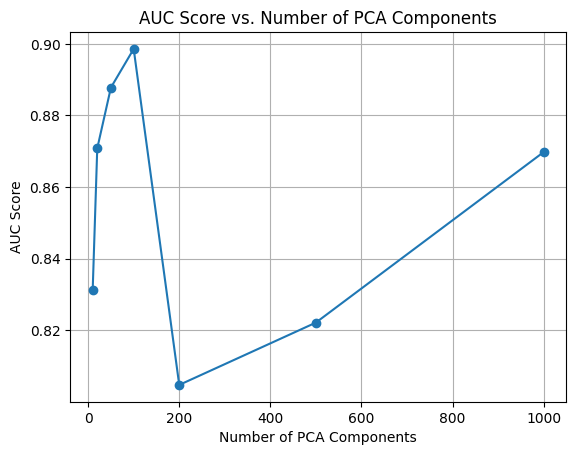

In [10]:
# Plot AUC scores against the number of PCA components
plt.plot(tpot_df["PCA Components"], tpot_df["AUC"], marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("AUC Score")
plt.title("AUC Score vs. Number of PCA Components")
plt.grid()
plt.show()

In [20]:
# Evaluate on the test set
y_pred_proba = tpot_df.loc[3, "Best model"].predict_proba(X_test_pca)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score:", test_auc)

Test AUC score: 0.8870866689871215


## Optuna

In [11]:
import optuna
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [13]:
# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [14]:
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])

    # Initialize the model with suggested hyperparameters
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(
        model,
        X_train_pca,
        y_train,
        scoring=make_scorer(roc_auc_score, needs_proba=True),
        cv=cv,
    )
    return auc_scores.mean()

In [15]:
# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-11-18 19:38:06,130] A new study created in memory with name: no-name-603b7b58-2e8c-4871-aa15-684058ef9bdd
c:\Users\predator\anaconda3\envs\dili-3.10\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
[I 2024-11-18 19:38:08,042] Trial 0 finished with value: 0.7273744895719187 and parameters: {'n_estimators': 388, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 0 with value: 0.7273744895719187.
c:\Users\predator\anaconda3\envs\dili-3.10\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve 

In [16]:
# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

Best hyperparameters: {'n_estimators': 433, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best AUC score: 0.7566980872295653


In [17]:
# Train final model with the best parameters
best_params = study.best_params
final_model = ExtraTreesClassifier(**best_params, random_state=42)
final_model.fit(X_train_pca, y_train)

ExtraTreesClassifier(max_depth=16, max_features='log2', min_samples_split=17,
                     n_estimators=433, random_state=42)

In [18]:
# Evaluate on the test set
y_pred_proba = final_model.predict_proba(X_test_pca)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score:", test_auc)

Test AUC score: 0.9099895579533589
